In [1]:
from classifiers.optimizer import tSPSA
from classifiers.callback import CostParamStorage
from classifiers.quantum.qasvm import QASVM

from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel

from qiskit.providers.aer import AerSimulator
from qiskit.providers.ibmq import IBMQ
from qiskit.circuit.library import RealAmplitudes
from qiskit.utils import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from tqdm.notebook import tqdm

import numpy as np
from matplotlib import pyplot as plt

## 1. 배경 및 주요 내용

### 서포트벡터머신 (SVM)

다른 라벨 ($y\in\left\{1, -1\right\}$)을 가진 데이터셋을 가장 잘 구분하는 고차원 평면을 찾는 기계학습 알고리즘. Strong Duality에 의해 커널 방법을 사용하여 비선형적 분류가 가능하다는 장점이 있다.
Hard-margin SVM의 분류과정은 다음과 같다.
\begin{equation}
\alpha^\star=\arg\max_{\alpha\ge0}\left[\sum_{i=0}^{M-1}\alpha_i-\frac{1}{2}\sum_{i,j=0}^{M-1}\alpha_i\alpha_jy_iy_jk(x_i, x_j)\right] : \sum_{i=0}^{M-1}\alpha_iy_i=0, \hat{y}=\mathrm{sgn}\left\{\sum_{i=0}^{M-1}\alpha^\star_iy_ik(\hat{x},x_i)+b\right\}
\end{equation}
### 양자근사서포트벡터머신 (QASVM)
SVM의 분류과정은 다음과 같이 변형될 수 있다.
\begin{equation}
\theta^\star=\arg\min_{\alpha(\theta)\in PV}\mathcal{L}_{\phi, \lambda}(\theta), \hat{y}=\mathrm{sgn}\left\{f_{\phi,\lambda}(\hat{x};\theta^\star)\right\}
\end{equation}
여기서 $\mathcal{L}_{\phi, \lambda}(\theta)=\sum_{i,j=0}^{M-1}\alpha_i(\theta)\alpha_j(\theta)y_iy_j\left(k(x_i, x_j)+\frac{1}{\lambda}\right)$, $f_{\phi,\lambda}(x,\theta)=\sum_{i=0}^{M-1}\alpha_i(\theta)y_i\left(k(x,x_i)+\frac{1}{\lambda}\right)$은 각각 목적, 결정 함수로 아래 양자회로를 통해 효율적으로 ($\mathcal{O}(M)$) 계산 가능하다.

<figure>
<img src="circ1.png" alt="circ1" width="400">
<figurecaption> 분류 양자 회로 </figurecaption>
</figure>
<figure>
<img src="circ2.png" alt="circ2" width="400">
<figurecaption> 훈련 양자 회로 </figurecaption>
</figure>

$\theta$는 $\alpha$를 근사적으로 인코딩하는 gate angle로, 최적화할 변수의 개수를 $\mathcal{O}(\mathrm{polylog}M)$으로 줄여준다. 양자 커널은 $k(\cdot, \cdot)=\left|\left<\phi(\cdot)\mid\phi(\cdot)\right>\right|^2$로 정의되기 때문에 적절한 양자 사상 함수 $\phi(\cdot)$을 정하는 것이 중요하다. 결론적으로, QASVM은 기존 양자근사서포트벡터머신보다 1. 적은 최적화 변수로 인한 점근적으로 빠른 훈련속도를 가지거나 2. 회로화가 가능하여 NISQ 장치에서 더 쉽게 구현할 수 있고, 3. 고전-양자 복합 알고리즘을 사용하여 오류에 강하다는 장점이 있다.



## 2. 시연과정
### Load IBMQ Device

IBMQ 계정으로 접속해 7개 이상의 큐빗을 가지는 양자컴퓨터에 접속한다.

In [2]:
import qiskit.tools.jupyter

if not IBMQ.active_account():
    IBMQ.load_account()
provider = IBMQ.get_provider(hub='strangeworks-hub')
backend = provider.get_backend('ibm_nairobi')
backend

<IBMQBackend('ibm_nairobi') from IBMQ(hub='strangeworks-hub', group='qc-com', project='runtime')>

In [3]:
MAXITER = 2**6
LAST_AVG = 2**4
TEST_SIZE = 16

### Toy Data Generation

블로우 구에서 임의의 두 극점을 훈련 데이터로, 극점을 지나는 원 상의 점을 테스트 데이터로 QASVM의 성능을 본다.

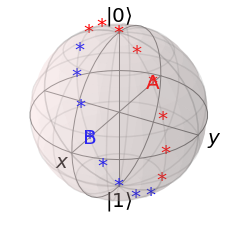

In [4]:
X = np.array([[np.pi/4, np.pi/3], [np.pi*5/4, np.pi/3]])
y=np.array([0, 1])
ax = plt.axes(projection='3d')

from qiskit.visualization.bloch import Bloch
B = Bloch(axes=ax)

def s2c(x):
    bloch = [1, x[0], x[1]]
    r, theta, phi = bloch[0], bloch[1], bloch[2]
    bloch[0] = r * np.sin(theta) * np.cos(phi)
    bloch[1] = r * np.sin(theta) * np.sin(phi)
    bloch[2] = r * np.cos(theta)
    return bloch

def c2s(bloch):
    x = [np.arccos(bloch[2]), np.arctan(bloch[1]/bloch[0])]
    return x

vecs = np.array(list(map(s2c, X)))
for v in vecs[y==0]:
    B.add_annotation(v, text='A', color='r')
for v in vecs[y==1]:
    B.add_annotation(v, text='B', color='b')
# B.add_annotation(vecs.mean(axis=0), text='M', color='k')
vecA = vecs[y==0].mean(axis=0)
vecA = vecA/np.linalg.norm(vecA)
vecB = vecs[y==1].mean(axis=0)
vecB = vecB/np.linalg.norm(vecB)
vecP = (vecA-vecB)/np.linalg.norm(vecA-vecB)
vecQ = -(vecA-vecB)/np.linalg.norm(vecA-vecB)
#B.add_annotation(vecP, text='P', color='r')
#B.add_annotation(vecQ, text='Q', color='b')

def test_data_gen(n, vecP, vecQ):
    Xt = np.array([np.linspace(0, 2*np.pi, n+1), c2s(vecP)[1]*np.ones(n+1)]).T
    Xt = Xt[1:]
    yt = np.where(np.dot(np.array(list(map(s2c, Xt))), vecP-vecQ)<0, 1, 0)
    return Xt, yt

Xt, yt = test_data_gen(TEST_SIZE, vecP, vecQ)

vecs = np.array(list(map(s2c, Xt)))
for v in vecs[yt==0]:
    B.add_annotation(v, text='*', color='r')
for v in vecs[yt==1]:
    B.add_annotation(v, text='*', color='b')

B.render()

## Training
### 비교를 위한 이론값 계산
$\mathcal{L}_{\phi, \lambda}(\theta)$를 $\alpha$에 대하여 CVXOPT로 광역최적화. 이는 고전적인 SVM의 결과와 수학적으로 동일하다. 양자컴퓨터로 학습한 결과와 이를 비교할 것이다.

In [5]:
svm = BinarySVM(Kernel('SingleQubit', reps=1), mutation='REDUCED_QASVM', C=None, k=10)
svm.fit(X, y)
Xtt, ytt = test_data_gen(100, vecP, vecQ)
svm_fvec = svm.f(Xtt)

### 훈련 양자회로 변환
훈련데이터를 임베팅한 QASVM 모델을 호출한다. 훈련 양자회로와 분류 양자회로를 양자컴퓨터에 맞게 번역한다.

42
41


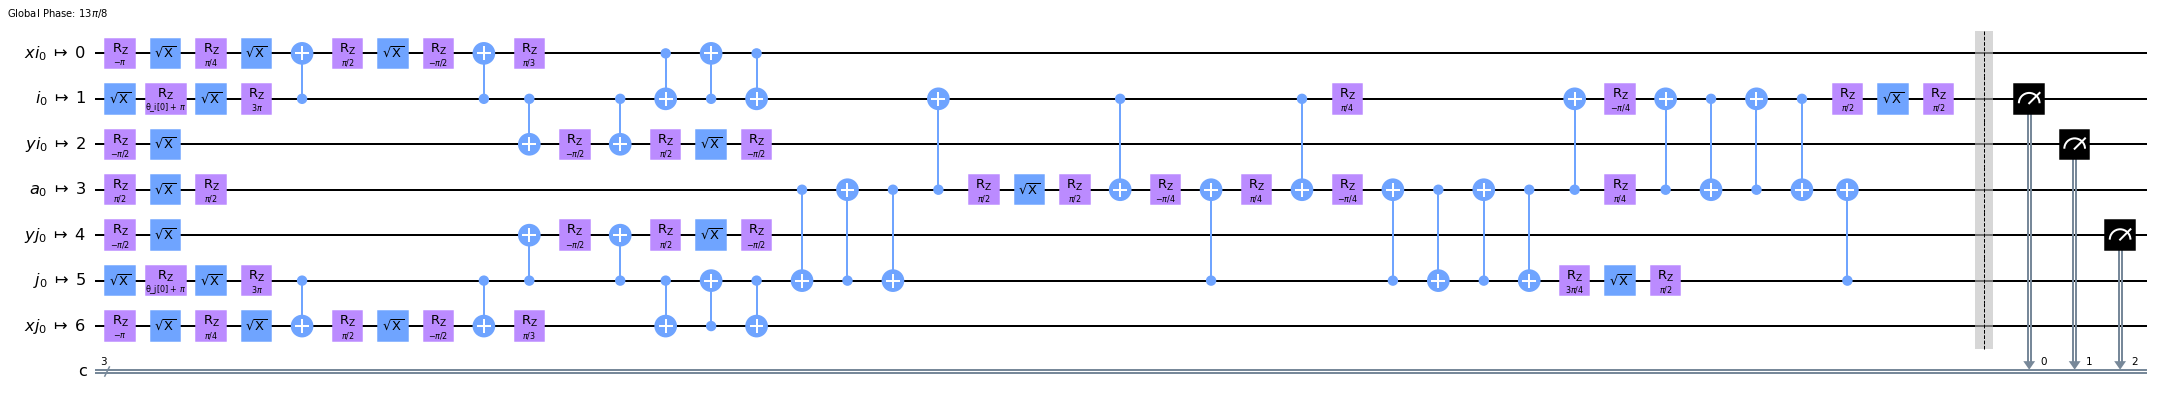

In [6]:
var_form = RealAmplitudes(1, reps=1, skip_final_rotation_layer=True)
quantum_instance = QuantumInstance(backend, shots=2**13, optimization_level=2, measurement_error_mitigation_cls=CompleteMeasFitter)
qasvm = QASVM(X, y, quantum_instance=quantum_instance, C=None, k=10, option='Bloch_sphere', var_form=var_form).dual
print(qasvm.second_order_circuit.depth())
print(qasvm.first_order_circuit.depth())
qasvm.second_order_circuit.draw(fold=-1, output='mpl', idle_wires=False)

### 양자 컴퓨터에서의 변분 학습
 VQA (변분 양자 얄고리즘)로 변수 최적화. 목적함수 계산은 양자컴퓨터에서, 변수 업데이트는 고전 컴퓨터에서 담당한다.

In [7]:
import qiskit.tools.jupyter
%qiskit_job_watcher

storage = CostParamStorage()
optimizer = tSPSA(maxiter=MAXITER, blocking=True, last_avg=LAST_AVG, callback=storage)
si_quantum_instance = QuantumInstance(AerSimulator.from_backend(backend), shots=2**13, optimization_level=2, measurement_error_mitigation_cls=CompleteMeasFitter)

#qasvm._quantum_instance = si_quantum_instance

for epoch in tqdm(list(range(1, MAXITER + 1))):
    optimizer.step(qasvm.cost_fn, qasvm.parameters)
    #if epoch == 2 * LAST_AVG:
    #    qasvm._quantum_instance = quantum_instance
    if storage.num_accepted() > 2 * LAST_AVG and storage.last_cost_avg(2 * LAST_AVG, ignore_rejected=True) < storage.last_cost_avg(LAST_AVG, ignore_rejected=True):
        break


Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

  0%|          | 0/64 [00:00<?, ?it/s]

/home/quic/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit/utils/run_circuits.py:695: UserWarning: max_credits is not a recognized runtime option and may be ignored by the backend.
  return backend.run(circuits, **run_kwargs)
(readout) measurement mitigation active. result.get_counts() has mitigated result, calibration data, and unmitigated result.
(readout) measurement mitigation active. result.get_counts() has mitigated result, calibration data, and unmitigated result.
(readout) measurement mitigation active. result.get_counts() has mitigated result, calibration data, and unmitigated result.
(readout) measurement mitigation active. result.get_counts() has mitigated result, calibration data, and unmitigated result.
(readout) measurement mitigation active. result.get_counts() has mitigated result, calibration data, and unmitigated result.
(readout) measurement mitigation active. result.get_counts() has mitigated result, calibration data, and unmitigated result.
(readout) measu

## Classification

In [8]:
import qiskit.tools.jupyter
%qiskit_job_watcher
qasvm.parameters = storage.last_avg(LAST_AVG, ignore_rejected=False)
fvec = qasvm.f(Xt)
if len(fvec)!=len(yt):
    fvec = fvec[4:]

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

Text(0, 0.5, 'classification score')

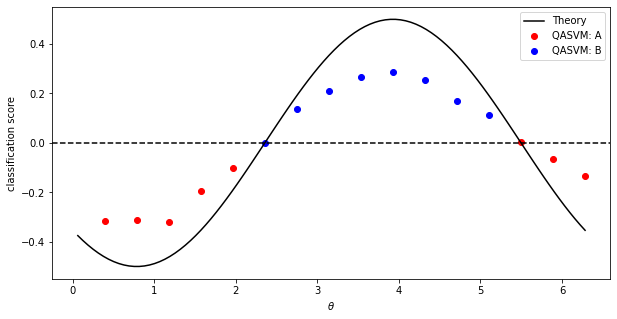

In [11]:
St = Xt[:, 0]
Stt = Xtt[:, 0]
plt.figure(figsize=(10, 5))
cal_fvec = fvec - np.mean(fvec)
plt.plot(Stt[:], svm_fvec, color='k', label='Theory')
plt.scatter(St[yt==0], cal_fvec[yt==0], c='r', marker='o', label='QASVM: A')
plt.scatter(St[yt==1], cal_fvec[yt==1], c='b', marker='o', label='QASVM: B')
plt.axhline(0, 0, 1, color='k', linestyle='--')
plt.legend()
plt.xlabel(r'$\theta$')
plt.ylabel('classification score')

이론값과 실제 계산값의 불일치는 양자컴퓨터의 오류 축적으로 인한 결과이다. 하지만 0을 기준으로 하는 분류는 충분히 성공적인 것을 알 수 있다.